## Get started
This tutorial will show you how asynctorch can be used. Make sure asynctorch, snnTorch and tonic have been installed! Tonic is not an automatic dependency of asynctorch because it is not required for all use cases. For CUDA support, make sure you have a working CUDA installation and the correct version of PyTorch installed.

Check our paper for more details: https://arxiv.org/abs/2408.05098

### Import packages

# load experiment dictionary


cuda
/home/jortg/Documents/uni/master/thesis/code/asynctorch_experiments/src/asynctorch_experiments


/home/jortg/Documents/uni/master/thesis/code/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting experiment
lif timestep
Updated build parameters: F->128
Updated build parameters: timestep_size->50000
Updated build parameters: tau_m->5000
Training session 1/2 (F_train: 128; trial 1/1):
experiment folder path: /home/jortg/Documents/uni/master/thesis/code/asynctorch_experiments/src/asynctorch_experiments/models/bbc51c5352ba2f775f3350d43e21a2aca8cb801a87667f34e70f295894a1fa1b/trial:0
Epoch 1/1:


100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


testing for epoch 1: F=128:0.479 F=16:0.497 F=8:0.532 F=4:0.545 
Updated build parameters: F->8
Updated build parameters: timestep_size->50000
Updated build parameters: tau_m->5000
Training session 2/2 (F_train: 8; trial 1/1):
experiment folder path: /home/jortg/Documents/uni/master/thesis/code/asynctorch_experiments/src/asynctorch_experiments/models/1b0a39e356417df4e98a918a36bb12ff107e15e30d92b16c1d1c7d8ff11563d8/trial:0
Epoch 1/1:


100%|██████████| 469/469 [00:23<00:00, 19.67it/s]


testing for epoch 1: F=128:0.098 F=16:0.100 F=8:0.116 F=4:0.135 


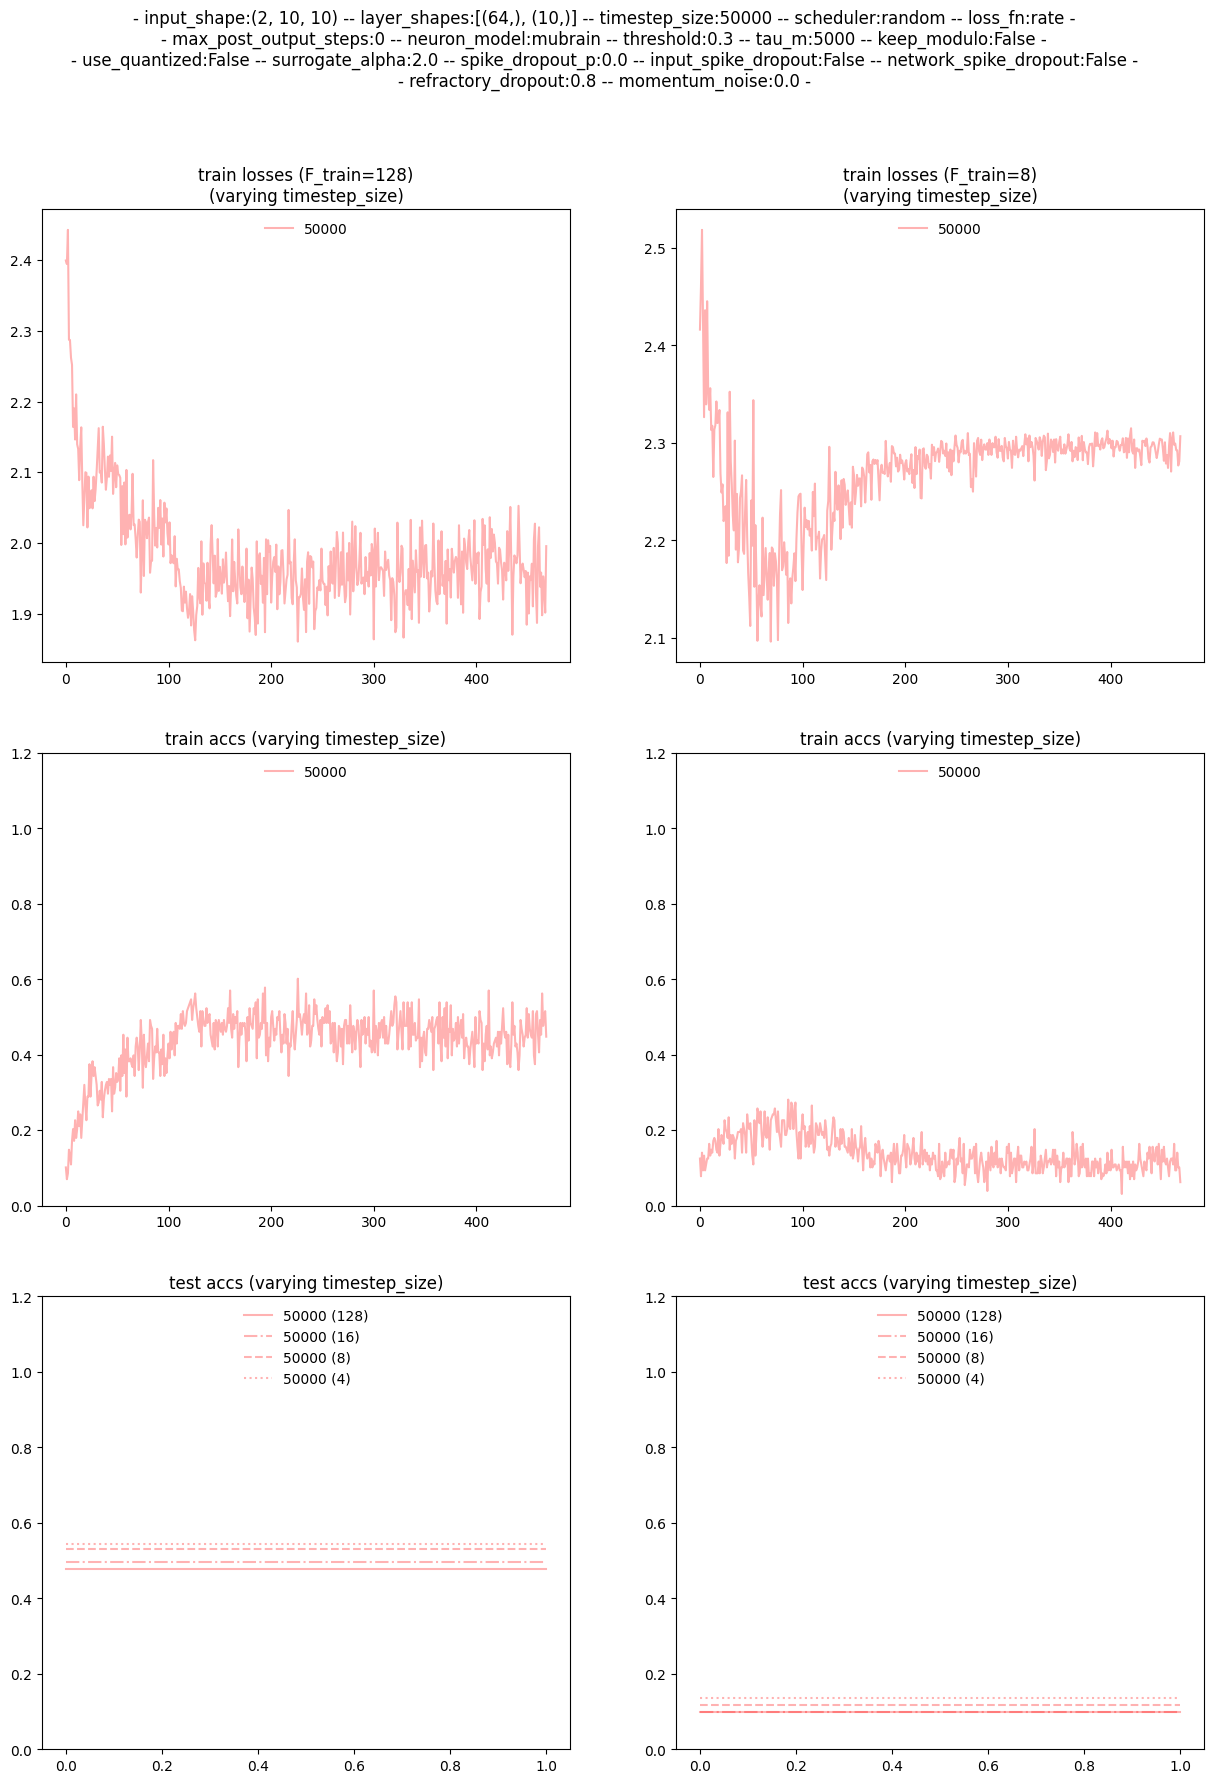

TypeError: 'Axes' object is not subscriptable

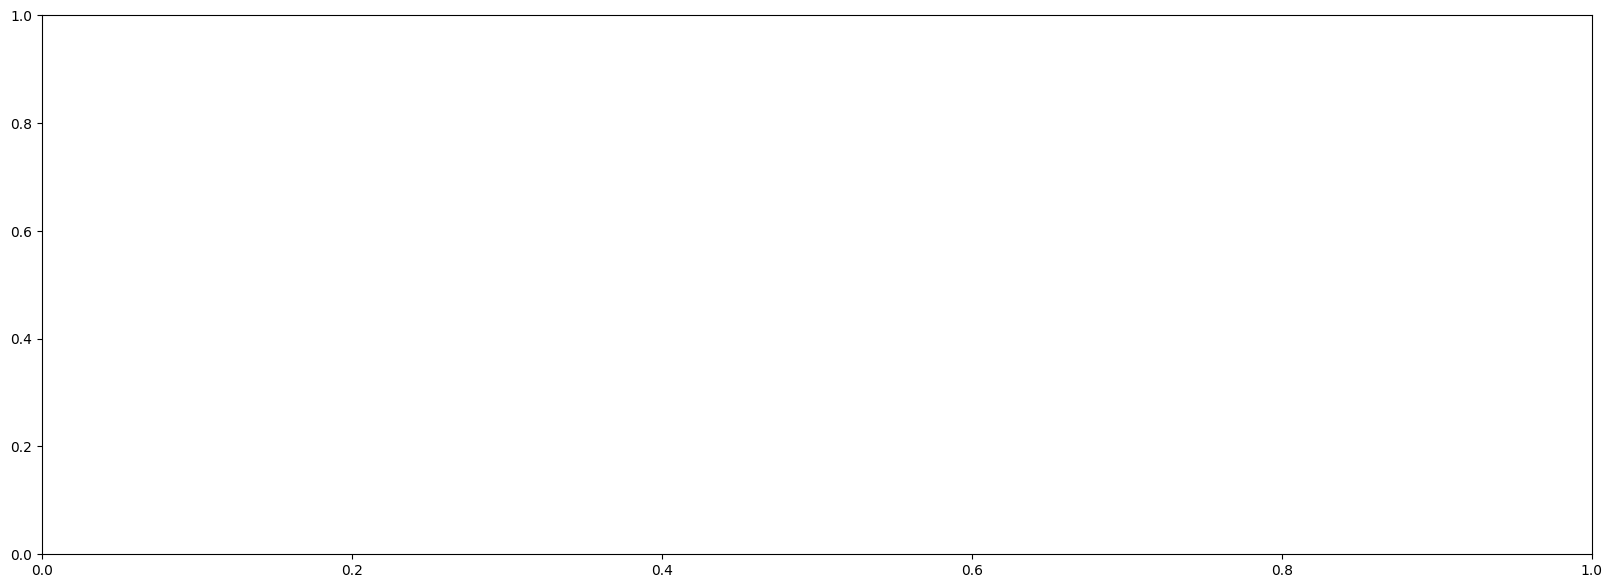

In [1]:

import os
import sys
import copy
import pickle

from dataclasses import dataclass, field, asdict
import numpy as np
from math import prod
from typing import NamedTuple
import torch
from pathlib import Path

import importlib
import pkgutil
import asynctorch_experiments

import asynctorch_experiments.traintools  # Main package to reload

# Import the necessary submodules or anything you need here after reloading

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

notebook_path = Path().resolve()
print(notebook_path)

import asynctorch_experiments
from asynctorch_experiments.n_mnist.experiment_dicts import EXPERIMENTS

from asynctorch_experiments.buildtools.experiment import Experiment

importlib.reload(asynctorch_experiments.n_mnist.experiment_dicts)
importlib.reload(asynctorch_experiments.buildtools.experiment)
importlib.reload(asynctorch_experiments.evaluation.plotting)
importlib.reload(asynctorch_experiments.traintools.train)
from asynctorch_experiments.n_mnist.experiment_dicts import EXPERIMENTS
from asynctorch_experiments.buildtools.experiment import Experiment
from asynctorch_experiments.traintools.train import ModelTrainer 
from asynctorch_experiments.evaluation.plotting import Plotter


reset_train_signals=True

signal_val=True
force_retest=False
exp_name = 'lif timestep'
verbose=False
print_path=True
normalize_weights=False

Experiment.run_exp(
    experiment_dict=EXPERIMENTS, 
    experiment_name=exp_name, 
    project_path=notebook_path,
    force_retest=force_retest,
    signal_retrain=reset_train_signals,
    retrain_signal_val=signal_val,
    verbose=verbose,
    print_path=print_path,
    normalize_weights=normalize_weights
)

In [ ]:
from asynctorch.nn.architecture.mixed_architecture import AsyncLayer, AsyncNetwork, MixedArchitecture
import torch
from asynctorch.nn.architecture.base_architecture import  BaseArchitecture
from torch import nn
from typing import List, Tuple, Union
from math import prod
from collections import namedtuple
import matplotlib.pyplot as plt
import torch.nn.init as init
import numpy as np
import math

def plot_tensor(tensor, title, nbins=100):
    fig, axs = plt.subplots(2,1, figsize=(6,8))
    axs[0].hist(tensor.flatten(), bins=nbins)
    axs[0].set_title(f'{title} (tensor histogram)')
    axs[1].imshow(tensor)
    axs[1].set_title(f'{title} (whole tensor)')
    plt.show()

QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])


def init_quantized_weights_(x, num_bits=8):
    fan_in, _ = init._calculate_fan_in_and_fan_out(x)
    qmin = -(2**num_bits - 1) //2 +1
    qmax = (2**num_bits - 1) //2
    print(f'qmin: {qmin}, qmax: {qmax}')
    x.uniform_(qmin, qmax)
    return x
    

def quantize_tensor(x, num_bits=8, verbose=True, return_int=True):
    
    # fan_in, fan_out = init._calculate_fan_in_and_fan_out(x)
    # alpha=np.sqrt(6 / fan_in)
    
    qmin = -(2.**num_bits - 1.) // 2 + 1
    qmax = (2.**num_bits - 1.) // 2
    qrange = qmax - qmin
    print(f'qmin: {qmin}, qmax: {qmax}, qrange: {qrange}')
    
    x_clamped = x.clamp(qmin, qmax) 
    plot_tensor(x_clamped, title='x scaled')
    scale=1
    zero_point = 0
    # scale=(2*alpha) / (qmax - qmin)
    
    # x_scaled_to_q = x_clamped / scale + qmin
    # plot_tensor(x_scaled_to_q, title='x scaled to q')
    
    x_int = x_clamped.round().int()
    
    # print(f'fan in: {fan_in}, fan out: {fan_out}')
    # print(f'alpha: {alpha}, scale: {scale}')
    
    # min_val, max_val = -0.4, 0.4
    # scale = (max_val - min_val) / (qmax - qmin)
    if verbose:
        print(f'quantizing... (qmin:{qmin}, qmax:{qmax}, scale:{scale})')
    
    return QTensor(tensor=x_int, scale=scale, zero_point=zero_point)


def dequantize_tensor(q_x):
    return q_x.scale * q_x.tensor.float() - q_x.zero_point

def forward(ctx, x, num_bits=8, min_val=None, max_val=None):

        x_old = x.clone()

        x_q = quantize_tensor(x,num_bits=num_bits)# min_val=min_val, max_val=max_val)
        print(f'quantized (scale: {x_q.scale}, zero point: {x_q.zero_point})')

        x_uq = dequantize_tensor(x_q)
        print('after dequantization')


        return  x_old, x_q.tensor, x_uq


def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None

In [ ]:



in_shape = 60
out_shape = 80
numbits=4



# fan_in, fan_out = init._calculate_fan_in_and_fan_out(test_tensor)
# alpha=np.sqrt(6 / fan_in)
# nn.init.kaiming_uniform_(test_tensor, a=alpha)


bit_counts= [4]
for numbits in bit_counts:  
    # create zero tensor
    test_tensor = torch.zeros((in_shape, out_shape))
    plot_tensor(test_tensor, f'original non-initialized: {numbits} bits')

    # initialize tensor
    init_quantized_weights_(test_tensor, num_bits=numbits)
    plot_tensor(test_tensor, f'original initialized: {numbits} bits')
    
    print('==========\nForward pass:\n==========')
    
    # perform forward quantization pass
    tensor_old, tensor_q, tensor_uq = forward(None, test_tensor, num_bits=numbits)
    
    plot_tensor(tensor_old, f'original dist: {numbits} bits')
    plot_tensor(tensor_q, f'quantized dist: {numbits} bits')
    plot_tensor(tensor_uq, f'unquantized dist: {numbits} bits')

    

In [ ]:
from asynctorch_experiments.buildtools.parameters import BuildParams
test_params = BuildParams(
    n_outputs=2,
    experiment_path=notebook_path
)







In [ ]:
!cd ../../asynctorch_experiments/ && pip install -e .

### Load data
For this, tonic is used. This can take same time when it is run for the first time.

In [ ]:
# @dataclass
# class BuildParams:
#     # network parameters
#     input_shape: list[int]
#     layer_shapes: list[tuple[int]]
#     n_outputs: int
#     timestep_size: int
#     scheduler: str
#     loss_fn: str
#     max_post_output_steps: int
#     # neuron parameters
#     neuron_model: str
#     threshold: float
#     tau_m: int
#     keep_modulo: bool
#     use_quantized: bool
#     # training parameters
#     surrogate_alpha: float
#     spike_dropout_p: float
#     input_spike_dropout: bool
#     network_spike_dropout: bool
#     refractory_dropout: float
#     momentum_noise: float
#     learning_rate: float
#     F: int

#     def get_model_path_old(self):
#         folder_path = os.path.join(notebook_path, "saved_models")
#         architecture_str = f"{','.join(map(str,self.input_shape))}_{'-'.join(map(str,self.layer_shapes))}"
#         network_str = f"{architecture_str}_{self.timestep_size}_{self.scheduler}"
#         neuron_model_str = f"{self.neuron_model}_{int(100*self.threshold)}_{self.tau_m}_{int(self.keep_modulo)}{int(self.use_quantized)}"
#         training_str = f"{int(100*self.refractory_dropout)}_{int(100*self.surrogate_alpha)}_{int(100*self.input_spike_dropout)}"
#         training_str += f"_{int(100*self.momentum_noise)}_{int(100*self.learning_rate)}_{self.F}"
#         model_path = f"{network_str}_{neuron_model_str}_{training_str}"
#         path = os.path.join(folder_path, model_path)
#         return path
    
#     def get_model_path(self):
#         folder_path = os.path.join(notebook_path, "saved_models")
#         experiment_path = str(self)
#         path = os.path.join(folder_path, experiment_path)
#         return path
    
#     def __str__(self) -> str:
#         """Override string conversion to show all parameters in a formatted way."""
#         return "_".join(f"{value}" for key, value in self.to_dict().items())
    
#     def to_dict(self) -> dict:
#         """Convert stored parameters to a dictionary."""
#         return asdict(self)



# def build_model(
#         build_params: BuildParams,
#         override_F: int | bool = False,
#         verbose: bool = False,
#         device='cpu'
#     ):

#     assert build_params.neuron_model in ["lif", "mubrain"]
#     assert build_params.scheduler in ['random', 'momentum']

#     F = override_F if override_F else build_params.F
    
#     module_per_layer = []

#     linear_module = q_nn.Linear if build_params.use_quantized else nn.Linear

#     shape_per_layer = [(prod(build_params.input_shape), )]
#     n_layers = len(build_params.layer_shapes)
#     for i in range(n_layers):
#         layer_in = prod(build_params.input_shape) if i == 0 else prod(build_params.layer_shapes[i-1])
#         layer_out = prod(build_params.layer_shapes[i])
#         module_per_layer.append(
#             linear_module(
#                 layer_in,
#                 layer_out, 
#                 bias=False)
#             )
#         shape_per_layer.append((layer_out, ))
#     neurons_per_layer = [prod(shape) for shape in shape_per_layer[1:]]
#     n_neurons = sum(neurons_per_layer)
    

#     # Network architecture
#     async_network = AsyncNetwork.build_sequential(
#         module_per_layer, 
#         shape_per_layer
#     ).to(device)

#     if verbose:
#         print(async_network)
#         print('neurons_per_layer: ', neurons_per_layer)
#         print('Number of neurons:',n_neurons)
#         print('Number of parameters:', sum(p.numel() for p in async_network.parameters() if p.requires_grad))
#     network_module = MixedArchitecture(async_network, device)

#     state_module=None

#     # Neuron model
#     spike_grad = ATan(alpha=build_params.surrogate_alpha)
#     if build_params.neuron_model == "lif":
#         if verbose:
#             print("lif model")
#         state_module = LIFState(
#             neurons_per_layer,
#             tau_m=build_params.tau_m,
#             membrane_threshold=build_params.threshold,
#             spike_grad=spike_grad,
#             device=device,
#             refrac_dropout=build_params.refractory_dropout, # Probability that a neuron can spike again in the same forward pass during training, check paper for more details
#         )
#     if build_params.neuron_model == "mubrain":
#         if build_params.verbose:
#             print("mubrain model")
#         state_module = Microbrain_IFState(
#             neurons_per_layer,
#             membrane_threshold=build_params.threshold,
#             spike_grad=spike_grad,
#             device=build_device,
#             refrac_dropout=build_params.refractory_dropout, # Probability that a neuron can spike again in the same forward pass during training, check paper for more details
#             keep_modulo=build_params.keep_modulo,
#         )
#     print(f"Building model (F={F})")

#     # Spike selection
#     spike_scheduler=None
#     if build_params.scheduler == 'random':
#         spike_scheduler = RandomSpikeScheduler(state_module)
#     if build_params.scheduler == 'momentum':
#         spike_scheduler = MomentumSpikeScheduler(state_module, lambda_=build_params.momentum_noise)


#     spike_selector_module = SpikeSelector(
#         network_module,
#         spike_scheduler,
#         forward_group_size=F, # How many spikes are processed in parallel per forward step
#         device=device,
#         prioritize_input=True,
#         log_queue_length=True
#     )
#     # Simulator and extensions
#     forward_step_extensions=[]
#     if build_params.input_spike_dropout or build_params.network_spike_dropout:
#         forward_step_extensions.append(
#             SpikeDropoutExtension(
#                 p=build_params.spike_dropout_p, 
#                 apply_to_input=build_params.input_spike_dropout, 
#                 apply_to_network=build_params.network_spike_dropout
#             )
#         )


#     if build_params.loss_fn == 'first_spike':
#         forward_step_extensions.append(
#             StopOnOutputExtension(
#                 n_neurons=n_neurons,
#                 n_outputs=build_params.n_outputs,
#                 max_post_output_steps=build_params.max_post_output_steps
#             )
#         )
         
#     async_simulator = AsyncSimulator(state_module, spike_selector_module, forward_step_extensions=forward_step_extensions)
    
#     return async_simulator, n_neurons


# def resample_data(build_params: BuildParams):
#     data_size_orig = tonic.datasets.NMNIST.sensor_size
#     data_size_downsampled = (*build_params.input_shape[1:], build_params.input_shape[0])
#     transform = transforms.Compose([
#         transforms.Downsample(sensor_size=data_size_orig, target_size=data_size_downsampled[:-1]),
#         transforms.ToFrame(sensor_size=data_size_downsampled, time_window=build_params.timestep_size),
#     ])
#     train_dataset = tonic.datasets.NMNIST(save_to="./data_small", transform=transform, train=True, first_saccade_only=True)
#     test_dataset = tonic.datasets.NMNIST(save_to="./data_small", transform=transform, train=False, first_saccade_only=True)
    
#     collate_fn = tonic.collation.PadTensors(batch_first=False)
#     return train_dataset, test_dataset, collate_fn
        






In [ ]:
def train_model(
        async_simulator, 
        train_dataset, 
        collate_fn, 
        n_neurons:int,
        build_params:BuildParams, 
        folder_path:str,
        n_epochs:int = 1,
        i:int = 0, 
        force_retrain:bool = False,
        device:str = 'cpu'
    ):

    assert build_params.loss_fn in ['rate', 'membrane']

    async_simulator_train, n_neurons_train = build_model(
        build_params, 
        verbose=build_params.verbose
        )

    if not os.path.exists(folder_path):
        # Create the folder if it doesn't exist
        os.makedirs(folder_path)


    statedict_filename_final = os.path.join(folder_path, f'model_{n_epochs}ep_{i}.pth')
    metrics_filename_final = os.path.join(folder_path, f'train_metrics_{n_epochs}{i}.pkl')

    if os.path.exists(statedict_filename_final) and os.path.exists(metrics_filename_final) and not force_retrain:
        # load state dict
        state_dict = torch.load(statedict_filename_final)
        async_simulator.load_state_dict(state_dict)
        # load training metrics
        with open(metrics_filename_final, "rb") as f:
            losses, accuracies = pickle.load(f)
        print(f'Loaded model from disk')
        
    else:
        print('Starting training')
        train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
        optimizer = torch.optim.Adam(async_simulator.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fns = {
            'rate': {'lf': SF.ce_rate_loss(), 'af': SF.accuracy_rate},
            'membrane': {'lf': SF.ce_max_membrane_loss(), 'af': SF.accuracy_rate},
            'first_spike': {'lf': SF.ce_temporal_loss(), 'af': SF.accuracy_rate}
        }
        loss_fn = loss_fns[build_params.loss_fn]['lf']
        accuracy_function = SF.accuracy_rate
        losses = []
        accuracies = []

        for epoch in range(build_params.n_epochs):
            

            print(f'Epoch {epoch+1}/{build_params.n_epochs}:')
            batch_iter = iter(train_dataloader)
            for data, targets in tqdm(batch_iter):
                data = data.to(device)
                targets = targets.to(device)
                async_simulator.reset_state() # Reset the state of the simulator (including the state of the neurons)

                # Forward pass
                ys = []
                for t in range(data.shape[0]):
                    ts_data = data[t].view(data[t].shape[0], -1)
                    spk_out = async_simulator(ts_data, dt=build_params.timestep_size)[:, n_neurons-build_params.n_outputs:]
                    ys.append(spk_out) 
                y = torch.stack(ys)
                loss = loss_fn(y, targets)
                losses.append(loss.item())
                accuracy = accuracy_function(y, targets)
                accuracies.append(accuracy)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        # save trained model and training metrics
        torch.save(async_simulator.state_dict(), statedict_filename)
        with open(metrics_filename, "wb") as f:
            pickle.dump((losses, accuracies), f)

    return


def test_model(async_simulator, test_dataset, collate_fn, n_neurons, build_params):
    
    async_simulator.eval()
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
    accuracies = []
    batch_sizes = []

    with torch.inference_mode():
        for data, targets in tqdm(test_dataloader):
            data = data.to(device)
            targets = targets.to(device)
            async_simulator.reset_state()
            ys = []
            for t in range(data.shape[0]):
                ts_data = data[t].float().view(data[t].shape[0], -1)
                
                spk_out = async_simulator(ts_data, dt=build_params.timestep_size)[:, n_neurons-build_params.n_outputs:]
                ys.append(spk_out) 
            y = torch.stack(ys).sum(dim=0)
            predictions = torch.argmax(y, dim=1)
            accuracy = predictions.eq(targets).float().mean().cpu().item()
            accuracies.append(accuracy)
            batch_sizes.append(data.shape[0])
    test_acc = sum([a*b for a, b in zip(accuracies, batch_sizes)]) / sum(batch_sizes)

    print("Test accuracy: ", test_acc)
    return test_acc

def plot_training_progress(losses, accuracies, F_size):
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(losses, color='C0')
    ax2.plot(accuracies, color='C1')

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss', color='C0')
    ax2.set_ylabel('Accuracy', color='C1')
    plt.title(f"F size: {F_size}")
    plt.show()

In [ ]:
def run_experiment(
    build_params,
    Fs_test,
    n_trials=1,
    force_retrain=False,
    force_retest=False
):
    folder_path = build_params.get_model_path()

    for i in range(n_trials):
        train_dataset, test_dataset, collate_fn = resample_data(build_params)
        
        # build train model 

        train_model(
            train_dataset, 
            collate_fn, 
            build_params,
            folder_path,
            i=i,
            force_retrain=force_retrain
        )
        
        
        test_filename = os.path.join(folder_path, f'test_scores_[{','.join(map(str, Fs_test))}]_{i}.pkl')

        if not os.path.exists(test_filename) or force_retest:
            test_accs = []

            for f in Fs_test:
                # build test model
                async_simulator_test, n_neurons_test = build_model(
                    build_params, 
                    override_F=f,
                    verbose=build_params.verbose
                )
                # replace state dict
                async_simulator_test.load_state_dict(async_simulator_train.state_dict().copy())
                # test model
                test_acc = test_model(async_simulator_test, test_dataset, collate_fn, n_neurons_train, build_params)
                print(f"test acc (F={f}): {test_acc}")
                test_accs.append(test_acc)

            with open(test_filename, "wb") as f:
                pickle.dump((Fs_test, test_accs), f)
        else:
            print('tests already done')
        

    return

In [ ]:
def load_test_data(
        build_params, 
        Fs_test
    ):
    all_test_results = []
    all_train_losses = []
    all_train_accuracies = []
    folder_path = build_params.get_model_path()
    i=0
    test_filename = os.path.join(folder_path, f'test_scores_[{','.join(map(str, Fs_test))}]_{i}.pkl')
    while os.path.exists(test_filename):
        # load_training metrics
        train_metrics_filename = os.path.join(folder_path, f'train_metrics_{i}.pkl')
        with open(train_metrics_filename, "rb") as train_file:
            train_losses, train_accuracies = pickle.load(train_file)
        all_train_losses.append(train_losses)
        all_train_accuracies.append(train_accuracies)

        # load test data
        with open(test_filename, "rb") as test_file:
            _, test_accs= pickle.load(test_file)
        
        all_test_results.append(test_accs)

        i += 1
        test_filename = os.path.join(folder_path, f'test_scores_[{','.join(map(str, Fs_test))}]_{i}.pkl')
    
    all_train_losses = np.array(all_train_losses)
    all_train_accuracies = np.array(all_train_accuracies)
    all_test_results = np.array(all_test_results)

    print(all_train_losses.shape)
    print(all_train_accuracies.shape)
    print(all_test_results.shape)
    print(f'Loaded {i} test files from disk')
    return i, all_train_losses, all_train_accuracies, all_test_results


def plot_experiment(build_params_list, Fs_test, experiment_name, colors_1=None, colors_2=None, markers=None, condition_labels=False):

    # collect results
    all_test_results = []
    all_train_accuracies = []
    all_train_losses = []
    Fs_train = []


    for build_params  in build_params_list:
        Fs_train.append(build_params.F)
        i, train_losses, train_accuracies, test_results = load_test_data(build_params, Fs_test)
        all_test_results.append(test_results)
        all_train_losses.append(train_losses)
        all_train_accuracies.append(train_accuracies)

    conditions = condition_labels if condition_labels else [f'F train: {f}' for f in Fs_train]
    n_conditions=len(conditions)

    if colors_1 is None:
        colors_1 = list(plt.get_cmap("tab20").colors)

    if colors_2 is None:
        colors_2 = list(plt.get_cmap("tab20").colors)

    if markers is None:
        markers = ['.' for i in range(n_conditions)]

    all_test_results = np.array(all_test_results)
    n_trials=all_test_results[0].shape[0]

    # plot results

    n_train = len(Fs_train)
    n_tests = len(Fs_test)

    fig, ax1 = plt.subplots()
    custom_lines = []
    labels = []

    ax2 = ax1.twinx()
    for i, label in enumerate(conditions):
        col_1 = colors_1[i]
        custom_lines.append(Line2D([0], [0], color=col_1, lw=1))
        labels.append(label)
        for j in range(n_trials):
            ax1.plot(all_train_losses[i][j], '--', label=label, c=col_1, alpha=2/(n_trials*n_conditions), lw=1)
            ax2.plot(all_train_accuracies[i][j], label=label, c=col_1, alpha=2/(n_trials*n_conditions), lw=1)

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss', color='C0')
    ax2.set_ylabel('Accuracy', color='C1')

    plt.legend(custom_lines, labels, bbox_to_anchor=(1.1, 1))
    plt.title(f"{experiment_name}\nloss and accuracy during training")
    plt.show()

    # print(all_test_results.shape)  # train Fs, trials, test Fs

    custom_lines = []
    labels = []
    for i, label in enumerate(conditions):
        xs = list(range(n_tests))
        col = colors_2[i]
        custom_lines.append(Line2D([0], [0], color=col, marker=markers[i], markersize=10, lw=1))
        labels.append(label)
        for j in range(n_trials):
            ys = all_test_results[i, j, :]

            plt.plot(xs, ys, marker=markers[i], markersize=10, label=label, c=col)

    plt.xticks(ticks=range(n_tests), labels=Fs_test)
    plt.xlabel('F at inference')
    plt.ylabel('test accuracy')
    plt.legend(custom_lines, labels, bbox_to_anchor=(1.4, 1))
    plt.title(f'{experiment_name}\nTest accuracy as a function of F at inference')
    plt.show()

# debug code

In [ ]:
fs_train = [128, 4]  # paper used 128, 16, 8, 4
fs_test = [128,16, 4]
experiment_parameters_list_debug =[]
n_trials_debug = 4

for i, f in enumerate(fs_train):
    experiment_parameters_debug = BuildParams(
        # network parameters
        input_shape=(2,34,34),
        layer_shapes=[(64, ), (64, ), (64, ), (10, )],
        n_outputs=10,
        timestep_size=10000,
        scheduler='momentum',
        loss_fn='rate',
        max_post_output_steps=1,
        # neuron parameters
        neuron_model='lif',
        threshold=0.3,
        tau_m=1000,
        keep_modulo=False,
        use_quantized=False,
        # training parameters
        surrogate_alpha=2,
        spike_dropout_p=0.,
        input_spike_dropout=False,
        network_spike_dropout=False,
        refractory_dropout=0.,
        momentum_noise=1e-6,
        learning_rate=5e-4,
        n_epochs=1,
        device=device,
        F=f,
        # experiment parameters
        verbose=False,
        experiment_path="explorative"
    )
    experiment_parameters_list_debug.append(experiment_parameters_debug)
    print(f"F train size: {f}")
    run_experiment(
        experiment_parameters_debug,
        Fs_test=fs_test,
        n_trials=n_trials_debug
    )


plot_experiment(experiment_parameters_list_debug, fs_test, 'debug')

# Reproduce paper

In [ ]:
fs_train_baseline = [128, 16, 8, 4]  # paper used 128, 16, 8, 4
fs_test_baseline = [128, 32, 16, 8, 4, 2, 1]

experiment_parameters_list_baseline =[]
n_trials_baseline = 5

for i, f in enumerate(fs_train_baseline):
    experiment_parameters_baseline = BuildParams(
        # network parameters
        input_shape=(2,34,34),
        layer_shapes=[(64, ), (64, ), (64, ), (10, )],
        n_outputs=10,
        timestep_size=10000,
        scheduler='momentum',
        loss_fn='rate',
        max_post_output_steps=1,
        # neuron parameters
        neuron_model='lif',
        threshold=0.3,
        tau_m=1000,
        keep_modulo=False,
        use_quantized=False,
        # training parameters
        surrogate_alpha=2,
        spike_dropout_p=0.,
        input_spike_dropout=False,
        network_spike_dropout=False,
        refractory_dropout=0.,
        momentum_noise=1e-6,
        learning_rate=5e-4,
        n_epochs=10,
        device=device,
        F=f,
        # experiment parameters
        verbose=False,
        experiment_path="explorative"
    )
    experiment_parameters_list_baseline.append(experiment_parameters_baseline)
    print(f"F train size: {f}")
    run_experiment(
        experiment_parameters_baseline,
        Fs_test=fs_test_baseline,
        n_trials=n_trials_baseline
    )


plot_experiment(experiment_parameters_list_baseline, fs_test_baseline, 'Baseline')

# 

# SHALLOW LIF

In [ ]:
train_fs = [128, 4]  # paper used 128, 16, 8, 4
test_fs = [128, 32, 16, 8, 4, 2, 1]
all_train_losses_shallow_lif = []
all_train_accs_shallow_lif = []
all_test_accs_shallow_lif = []
experiment_parameters_shallow_lif = BuildParams(
    # network parameters
    input_shape=(2,34,34),
    layer_shapes=[(64, ),  (10, )],
    n_outputs=10,
    timestep_size=10000,
    scheduler='momentum',
    # neuron parameters
    neuron_model='lif',
    threshold=0.3,
    tau_m=1000,
    keep_modulo=False,
    use_quantized=False,
    # training parameters
    refrac_dropout=0.8,
    surrogate_alpha=2,
    input_spike_dropout=0.25,
    refractory_dropout=0.8,
    momentum_noise=1e-6,
    learning_rate=5e-4,
    n_epochs=10,
    device=device,
    # experiment parameters
    verbose=False
)


for i, f in enumerate(train_fs):
    print(f"F train size: {f}")
    losses_train, accuracies_train, test_accs = run_experiment(
        experiment_parameters_shallow_lif,
        F_train=f,
        Fs_test=test_fs
    )
    all_train_losses_shallow_lif.append(losses_train)
    all_train_accs_shallow_lif.append(accuracies_train)
    all_test_accs_shallow_lif.append(test_accs)

In [ ]:
plot_f_accs(train_fs, test_fs, all_train_losses_shallow_lif, all_train_accs_shallow_lif, all_test_accs_shallow_lif, 'LIF shallow')

In [ ]:
train_fs = [128, 4]  # paper used 128, 16, 8, 4
test_fs = [128, 32, 16, 8, 4, 2, 1]
all_train_losses_shallow_lif_downsampled = []
all_train_accs_shallow_lif_downsampled = []
all_test_accs_shallow_lif_downsampled = []
experiment_parameters_shallow_lif_downsampled = BuildParams(
    # network parameters
    input_shape=(2,10,10),
    layer_shapes=[(64, ),  (10, )],
    n_outputs=10,
    timestep_size=10000,
    scheduler='momentum',
    # neuron parameters
    neuron_model='lif',
    threshold=0.3,
    tau_m=1000,
    keep_modulo=False,
    use_quantized=False,
    # training parameters
    refrac_dropout=0.8,
    surrogate_alpha=2,
    input_spike_dropout=0.25,
    refractory_dropout=0.8,
    momentum_noise=1e-6,
    learning_rate=5e-4,
    n_epochs=10,
    device=device,
    # experiment parameters
    verbose=False
)


for i, f in enumerate(train_fs):
    print(f"F train size: {f}")
    losses_train, accuracies_train, test_accs = run_experiment(
        experiment_parameters_shallow_lif_downsampled,
        F_train=f,
        Fs_test=test_fs
    )
    all_train_losses_shallow_lif_downsampled.append(losses_train)
    all_train_accs_shallow_lif_downsampled.append(accuracies_train)
    all_test_accs_shallow_lif_downsampled.append(test_accs)

In [ ]:
plot_f_accs(
    train_fs,
    test_fs, 
    all_train_losses_shallow_lif_downsampled, 
    all_train_accs_shallow_lif_downsampled, 
    all_test_accs_shallow_lif_downsampled, 
    'LIF shallow downsampled'
)

In [ ]:
train_fs = [128, 4]  # paper used 128, 16, 8, 4
test_fs = [128, 32, 16, 8, 4, 2, 1]
all_train_losses_shallow_mubrain = []
all_train_accs_shallow_mubrain = []
all_test_accs_shallow_mubrain = []
experiment_parameters_shallow_mubrain = BuildParams(
    # network parameters
    input_shape=(2,10,10),
    layer_shapes=[(64, ),  (10, )],
    n_outputs=10,
    timestep_size=10000,
    scheduler='momentum',
    # neuron parameters
    neuron_model='mubrain',
    threshold=0.3,
    tau_m=1000,
    keep_modulo=False,
    use_quantized=False,
    # training parameters
    refrac_dropout=0.8,
    surrogate_alpha=2,
    input_spike_dropout=0.25,
    refractory_dropout=0.8,
    momentum_noise=1e-6,
    learning_rate=5e-4,
    n_epochs=10,
    device=device,
    # experiment parameters
    verbose=False
)


for i, f in enumerate(train_fs):
    print(f"F train size: {f}")
    losses_train, accuracies_train, test_accs = run_experiment(
        experiment_parameters_shallow_mubrain,
        F_train=f,
        Fs_test=test_fs
    )
    all_train_losses_shallow_mubrain.append(losses_train)
    all_train_accs_shallow_mubrain.append(accuracies_train)
    all_test_accs_shallow_mubrain.append(test_accs)

In [ ]:
plot_f_accs(
    train_fs,
    test_fs, 
    all_train_losses_shallow_mubrain, 
    all_train_accs_shallow_mubrain, 
    all_test_accs_shallow_mubrain, 
    'mubrain shallow downsampled'
)

In [ ]:
train_fs = [128, 4]  # paper used 128, 16, 8, 4
test_fs = [128, 32, 16, 8, 4, 2, 1]
all_train_losses_shallow_mubrain_random = []
all_train_accs_shallow_mubrain_random = []
all_test_accs_shallow_mubrain_random = []
experiment_parameters_shallow_mubrain_random = BuildParams(
    # network parameters
    input_shape=(2,10,10),
    layer_shapes=[(64, ),  (10, )],
    n_outputs=10,
    timestep_size=10000,   # explore input window size --> higher spike counts might have more effect
    scheduler='random',
    # neuron parameters
    neuron_model='mubrain',
    threshold=0.3,
    tau_m=1000,    # explore effect
    keep_modulo=False,
    use_quantized=False,
    # training parameters
    refrac_dropout=0.8,
    surrogate_alpha=2,
    input_spike_dropout=0.25,  # test completrely without dropout
    refractory_dropout=0.8,
    momentum_noise=1e-6,
    learning_rate=5e-4,
    n_epochs=10,
    device=device,
    # experiment parameters
    verbose=False
)


for i, f in enumerate(train_fs):
    print(f"F train size: {f}")
    losses_train, accuracies_train, test_accs = run_experiment(
        experiment_parameters_shallow_mubrain_random,
        F_train=f,
        Fs_test=test_fs
    )
    all_train_losses_shallow_mubrain_random.append(losses_train)
    all_train_accs_shallow_mubrain_random.append(accuracies_train)
    all_test_accs_shallow_mubrain_random.append(test_accs)

In [ ]:
plot_f_accs(
    train_fs,
    test_fs, 
    all_train_losses_shallow_mubrain_random, 
    all_train_accs_shallow_mubrain_random, 
    all_test_accs_shallow_mubrain_random, 
    'mubrain shallow downsampled\nrandom spike selection'
)

In [ ]:
fs_train_timestep = [128, 4]  # paper used 128, 16, 8, 4
fs_test_timestep = [128, 32, 16, 8, 4, 2, 1]

experiment_parameters_list_timestep =[]
n_trials_timestep = 1
n_fs_train = len(fs_train_timestep)

timesteps = [5000,  15000,  70000]
n_timesteps = len(timesteps)
for timestep in timesteps:
    for i, f in enumerate(fs_train_timestep):
        experiment_parameters_timestep = BuildParams(
            # network parameters
            input_shape=(2,10,10),
            layer_shapes=[(64, ),  (10, )],
            n_outputs=10,
            timestep_size=timestep,
            scheduler='momentum',
            # neuron parameters
            neuron_model='mubrain',
            threshold=0.3,
            tau_m=1000,
            keep_modulo=False,
            use_quantized=False,
            # training parameters
            refrac_dropout=0.8,
            surrogate_alpha=2,
            input_spike_dropout=0,
            refractory_dropout=0.8,
            momentum_noise=1e-6,
            learning_rate=5e-4,
            n_epochs=1,
            device=device,
            F=f,
            # experiment parameters
            verbose=False,
            experiment_path="explorative"
        )
        experiment_parameters_list_timestep.append(experiment_parameters_timestep)
        print(f"F train size: {f}")
        run_experiment(
            experiment_parameters_timestep,
            Fs_test=fs_test_timestep,
            n_trials=n_trials_timestep
        )


available_colors = list(plt.get_cmap("tab20").colors)
available_markers = ['.', '*', 'v', '1', '2', '3']

conditions = []
markers = []
colors_1=[]
colors_2=[]

for i, timestep in enumerate(timesteps):
    for j, f in enumerate(fs_train):
        conditions.append(f'dt={timestep}, F_t={f}')
        colors_1.append(available_colors[n_fs_train*i + j])
        colors_2.append(available_colors[n_fs_train*i +j])
        colors_2.append(available_colors[n_fs_train*i +j])
        markers.append(available_markers[j])
print(conditions)

plot_experiment(
    experiment_parameters_list_timestep, 
    fs_test_timestep, 
    'Varying time window',
    colors_1=colors_1,
    colors_2=colors_2,
    markers=markers,
    condition_labels=conditions
)

In [ ]:
plot_experiment(
    experiment_parameters_list_timestep, 
    fs_test_timestep, 'Varying time window')

# test more timewindows
# non-ratecoding -> mem pot --> disable spiking in final layer
# no regularixzation
# display the data
# quantization



### Define the network and parameters for simulator
We provide two network architectures. An architecture consists of just the connecting layer, so not the (spiking) activations / neurons. You can use the layers from PyTorch, like nn.Conv2d and nn.Linear. On top of that, you must also provide their input shape. 
In a later cell, these definitions will be used to construct the network. We assume here that you want a fully sequential network. For more advanced structures like residual connections, you must manually connect each layer to neurons. This will be discussed in another tutorial (to be added later). For now, after running "CNN" or "Linear", just run the "Build" cell to construct.

#### CNN

#### Linear

#### Build
The building process consists of first taking the network definitions from the previous cells and then using those to construct an architecture module. This will provide the logic for how to forward spikes and currents. How the neurons behave is defined in a state module, in this case LIF neurons are used. The last step is defining how spikes are selected and then combining everything into the simulator environment. Optionally, "extensions" can be provided. In this example, spike dropout will be used for regularization, but only applied to the input. Different from torch dropout, it is not directly included in the architecture, but rather added as an extension.

## Start training
For training, we use the standard PyTorch training loop with some snnTorch specific functions. Instead of calling a forward pass on the network, we call the forward function of the simulator. This function takes the input data and the time step, and returns the output spikes of the network. The output spikes can then be used to calculate the loss and update the weights of the network.

### Plot the training progress

## Test the model

## microbrain compatible MNIST